<div style="height:200px;width:100%;margin: 0;">
    <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/34547/logos/header.png?t=2022-02-15-22-37-27" style="width:100%;" />
</div>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="credits"><center>Credits</center></h3>

This is the reverse engineering of the [hengck23 discussion](https://www.kaggle.com/code/hengck23/lb-0-75-variable-size-swin-transformer-v1-and-v2).<br>
Please upvote both discussion/notebooks if you are planning to use Swin Transformers or any part of the code.

**hengck23 owner Disclaimer**

[1] the code is taken from a larger project and is by no means complete. It will has missing import modules, etc. But these are trival functions that you can ignore or fill in yourself.

[2] you are free to use, modify the code for your own notebook or submission

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="imports"><center>Imports</center></h3>

In [1]:
import os
import cv2
import time
import random

import torch
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler 
from torch.utils.data import SequentialSampler
import torch.nn.functional as F
# from torchmetrics.functional import dice_score
from torch.optim.lr_scheduler import StepLR
import tifffile

is_amp = True
import logging
import pandas as pd
from sklearn.model_selection import KFold

import numpy as np
from itertools import repeat
import collections.abc

import warnings
warnings.filterwarnings('ignore')

/home/lakshita/somusan/hubmap_kaggle/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="paths"><center>Paths</center></h3>

In [2]:
!mkdir -p ./result
!mkdir -p ./checkpoint

root_dir = '.'
pretrain_dir = '/home/lakshita/somusan/hubmap_kaggle/nbs/coat-only-small'

TRAIN = '/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size'
MASKS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks'
LABELS = '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv'

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="additionals"><center>Additionals</center></h3>

In [3]:
def image_to_tensor(image, mode='bgr'): #image mode
    if mode=='bgr':
        image = image[:,:,::-1]
    x = image
    x = x.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x, dtype=torch.float)
    return x


def mask_to_tensor(mask):
    x = mask
    x = torch.tensor(x, dtype=torch.float)
    return x


tensor_list = ['mask', 'image', 'organ']

def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        if k in tensor_list:
            v = torch.stack(v)
        d[k] = v

    d['mask'] = d['mask'].unsqueeze(1)
    d['organ'] = d['organ'].reshape(-1)
    return d


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_2tuple = _ntuple(2)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

        
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'
    
    
class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
    IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

    def __init__(self,):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1,3,1,1))
        self.register_buffer('std', torch.ones(1,3,1,1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x-self.mean)/self.std
        return x
    
    
def message(mode='print'):
    asterisk = ' '
    if mode==('print'):
        loss = batch_loss
    if mode==('log'):
        loss = train_loss
        if (iteration % iter_save == 0): asterisk = '*'

    text = \
        ('%0.2e   %08d%s %6.2f | '%(rate, iteration, asterisk, epoch,)).replace('e-0','e-').replace('e+0','e+') + \
        '%4.3f  %4.3f  %4.4f  %4.3f   | '%(*valid_loss,) + \
        '%4.3f  %4.3f   | '%(*loss,) + \
        '%s End' % ((time.time() - start_timer))

    return text

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="randoms"><center>Random choice</center></h3>

In [4]:
def valid_augment5(image, mask, organ):
    #image, mask  = do_crop(image, mask, image_size, xy=(None,None))
    return image, mask

def train_augment5b(image, mask, organ):
    image, mask = do_random_flip(image, mask)
    image, mask = do_random_rot90(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_noise(image, mask, mag=0.1),
        lambda image, mask: do_random_contast(image, mask, mag=0.40),
        lambda image, mask: do_random_hsv(image, mask, mag=[0.40, 0.40, 0])
    ], 2): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask: (image, mask),
        lambda image, mask: do_random_rotate_scale(image, mask, angle=45, scale=[0.50, 2.0]),
    ], 1): image, mask = fn(image, mask)

    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="augmentations"><center>Augmentations</center></h3>

In [5]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask
    
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + random.uniform(-1,1)*mag[1])
    v =  v*(1 + random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask

def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask

def do_random_rotate_scale(image, mask, angle=30, scale=[0.8,1.2] ):
    angle = np.random.uniform(-angle, angle)
    scale = np.random.uniform(*scale) if scale is not None else 1
    
    height, width = image.shape[:2]
    center = (height // 2, width // 2)
    
    transform = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine( image, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask  = cv2.warpAffine( mask, transform, (width, height), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [6]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [7]:
image_size = 512 #1024

class HubmapDataset(Dataset):
    def __init__(self, df, augment=None):

        self.df = df
        self.augment = augment
        self.length = len(self.df)
        self.organ_to_label = {'kidney' : 0,
                               'prostate' : 1,
                               'largeintestine' : 2,
                               'spleen' : 3,
                               'lung' : 4}

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        #fname = self.fnames[index]
        #img_id = self.df.iloc[index, 'id']
        d = self.df.iloc[index]
        img_height = self.df.loc[index, 'img_height']
        img_width = self.df.loc[index, 'img_width']
        organ = self.organ_to_label[d.organ]

        #image = cv2.cvtColor(tifffile.imread(os.path.join(TRAIN, f'{d.id}.tiff')), cv2.COLOR_BGR2RGB)
        
        image = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, f'{d.id}.png')), cv2.COLOR_BGR2RGB)
        
        rle_mask = self.df.loc[index, 'rle']
        mask = rle_decode(rle_mask, (img_height, img_width))
        #mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = 2)
        #print(mask.shape)
        
        image = image.astype(np.float32)/255
        #mask  = mask.astype(np.float32)/255
        mask = mask.astype(np.float32)

        s = d.pixel_size/0.4 * (image_size/3000)
        image = cv2.resize(image,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)

        if self.augment is not None:
            image, mask = self.augment(image, mask, organ)


        r ={}
        r['index']= index
        r['organ'] = torch.tensor([organ], dtype=torch.long)
        r['image'] = image_to_tensor(image)
        r['mask' ] = mask_to_tensor(mask)
        return r

In [8]:
df = pd.read_csv(LABELS)
ds = HubmapDataset(df)
ds[0]["image"].shape

torch.Size([3, 512, 512])

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="patching"><center>Image Patching</center></h3>

In [9]:
import pdb

class MixUpSample(nn.Module):
	def __init__( self, scale_factor=2):
		super().__init__()
		self.mixing = nn.Parameter(torch.tensor(0.5))
		self.scale_factor = scale_factor
	
	def forward(self, x):
		x = self.mixing *F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False) \
			+ (1-self.mixing )*F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
		return x

#https://github.com/lhoyer/DAFormer/blob/master/mmseg/models/decode_heads/daformer_head.py
def Conv2dBnReLU(in_channel, out_channel, kernel_size=3, padding=1,stride=1, dilation=1):
	return nn.Sequential(
		nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, bias=False),
		nn.BatchNorm2d(out_channel),
		nn.ReLU(inplace=True),
	)

class ASPP(nn.Module):
	
	def __init__(self,
				 in_channel,
				 channel,
				 dilation,
				 ):
		super(ASPP, self).__init__()
		
		self.conv = nn.ModuleList()
		for d in dilation:
			self.conv.append(
				Conv2dBnReLU(
					in_channel,
					channel,
					kernel_size=1 if d == 1 else 3,
					dilation=d,
					padding=0 if d == 1 else d,
				)
			)
		
		self.out = Conv2dBnReLU(
			len(dilation) * channel,
			channel,
			kernel_size=3,
			padding=1,
			)
	
	def forward(self, x):
		aspp = []
		for conv in self.conv:
			aspp.append(conv(x))
		aspp = torch.cat(aspp, dim=1)
		out = self.out(aspp)
		return out

#DepthwiseSeparable
class DSConv2d(nn.Module):
	def __init__(self,
				 in_channel,
				 out_channel,
				 kernel_size,
				 stride   = 1,
				 padding  = 0,
				 dilation = 1
		):
		super().__init__()
		
		self.depthwise = nn.Sequential(
			nn.Conv2d( in_channel, in_channel, kernel_size, stride=stride, padding=padding, dilation=dilation),
			nn.BatchNorm2d(in_channel),
			nn.ReLU(inplace=True)
		)
		
		self.pointwise = nn.Sequential(
			nn.Conv2d( in_channel, out_channel, kernel_size=1, stride=1, padding=0),
			nn.BatchNorm2d(out_channel),
			nn.ReLU(inplace=True)
		)
	
	def forward(self, x):
		x = self.depthwise(x)
		x = self.pointwise(x)
		return x

class DSASPP(nn.Module):
	
	def __init__(self,
				 in_channel,
				 channel,
				 dilation,
				 ):
		super(DSASPP, self).__init__()
		
		self.conv = nn.ModuleList()
		for d in dilation:
			if d == 1:
				self.conv.append(
					Conv2dBnReLU(
						in_channel,
						channel,
						kernel_size=1 if d == 1 else 3,
						dilation=d,
						padding=0 if d == 1 else d,
					)
				)
			else:
				self.conv.append(
					DSConv2d(
						in_channel,
						channel,
						kernel_size=3,
						dilation=d,
						padding=d,
					)
				)
		
		self.out = Conv2dBnReLU(
			len(dilation) * channel,
			channel,
			kernel_size=3,
			padding=1,
		)
	 
	def forward(self, x):
		aspp = []
		for conv in self.conv:
			aspp.append(conv(x))
		aspp = torch.cat(aspp, dim=1)
		out = self.out(aspp)
		return out

	
##############################################################################################33
#   [32, 64, 160, 256],
class DaformerDecoder(nn.Module):
	def __init__(
			self,

			encoder_dim = [152, 320, 320, 320,320],
			decoder_dim = 320,
			dilation = [1, 6, 12, 18],
			use_bn_mlp  = True,
			fuse = 'conv3x3',
	):
		super().__init__()
		self.mlp = nn.ModuleList([
			nn.Sequential(
				# Conv2dBnReLU(dim, decoder_dim, 1, padding=0), #follow mmseg to use conv-bn-relu
				*(
				  ( nn.Conv2d(dim, decoder_dim, 1, padding= 0,  bias=False),
					nn.BatchNorm2d(decoder_dim),
					nn.ReLU(inplace=True),
				)if use_bn_mlp else
				  ( nn.Conv2d(dim, decoder_dim, 1, padding= 0,  bias=True),)
				),
				
				MixUpSample(2**i) if i!=0 else nn.Identity(),
			) for i, dim in enumerate(encoder_dim)])
	  
		if fuse=='conv1x1':
			self.fuse = nn.Sequential(
				nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 1, padding=0, bias=False),
				nn.BatchNorm2d(decoder_dim),
				nn.ReLU(inplace=True),
			)
		
		if fuse=='conv3x3':
			self.fuse = nn.Sequential(
				nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 3, padding=1, bias=False),
				nn.BatchNorm2d(decoder_dim),
				nn.ReLU(inplace=True),
			)
		
		if fuse=='aspp':
			self.fuse = ASPP(
				decoder_dim*len(encoder_dim),
				decoder_dim,
				dilation,
			)
			
		if fuse=='ds-aspp':
			self.fuse = DSASPP(
				decoder_dim*len(encoder_dim),
				decoder_dim,
				dilation,
			)
		
	
	def forward(self, feature):
		
		out = []
		for i,f in enumerate(feature):
			f = self.mlp[i](f)
			out.append(f)
			# pdb.set_trace()
			#print(f.shape)
		x = self.fuse(torch.cat(out, dim = 1))
		return x, out  

class daformer_conv1x1 (DaformerDecoder):
	def __init__(self, **kwargs):
		super(daformer_conv1x1, self).__init__(
			fuse = 'conv1x1',
			**kwargs
		)

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

from einops import rearrange
from functools import partial
from torch import nn, einsum
import pdb


#---------------------------------------------
#https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py#L15
class LayerNorm2d(nn.Module):
	def __init__(self, dim, eps=1e-6):
		super().__init__()
		self.dim = dim
		self.weight = nn.Parameter(torch.ones(dim))
		self.bias = nn.Parameter(torch.zeros(dim))
		self.eps = eps
	
	def forward(self, x):
		batch_size,C,H,W = x.shape
		#assert C==self.dim, 'C=%d, self.dim=%d'%(C,self.dim)
		#print('C=%d, self.dim=%d'%(C,self.dim))
		
		u = x.mean(1, keepdim=True)
		s = (x - u).pow(2).mean(1, keepdim=True)
		x = (x - u) / torch.sqrt(s + self.eps)
		x = self.weight[:, None, None] * x + self.bias[:, None, None]
		return x
#---------------------------------------------

def _cfg_coat(url='', **kwargs):
	return {
		'url': url,
		'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
		'crop_pct': .9, 'interpolation': 'bicubic',
		'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
		'first_conv': 'patch_embed.proj', 'classifier': 'head',
		**kwargs
	}


class Mlp(nn.Module):
	""" Feed-forward network (FFN, a.k.a. MLP) class. """
	def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
		super().__init__()
		out_features = out_features or in_features
		hidden_features = hidden_features or in_features
		self.fc1 = nn.Linear(in_features, hidden_features)
		self.act = act_layer()
		self.fc2 = nn.Linear(hidden_features, out_features)
		self.drop = nn.Dropout(drop)
	
	def forward(self, x):
		x = self.fc1(x)
		x = self.act(x)
		x = self.drop(x)
		x = self.fc2(x)
		x = self.drop(x)
		return x


class ConvRelPosEnc(nn.Module):
	""" Convolutional relative position encoding. """
	def __init__(self, Ch, h, window):
		"""
		Initialization.
			Ch: Channels per head.
			h: Number of heads.
			window: Window size(s) in convolutional relative positional encoding. It can have two forms:
					1. An integer of window size, which assigns all attention heads with the same window size in ConvRelPosEnc.
					2. A dict mapping window size to #attention head splits (e.g. {window size 1: #attention head split 1, window size 2: #attention head split 2})
					   It will apply different window size to the attention head splits.
		"""
		super().__init__()
		
		if isinstance(window, int):
			window = {window: h}                                                         # Set the same window size for all attention heads.
			self.window = window
		elif isinstance(window, dict):
			self.window = window
		else:
			raise ValueError()
		
		self.conv_list = nn.ModuleList()
		self.head_splits = []
		for cur_window, cur_head_split in window.items():
			dilation = 1                                                                 # Use dilation=1 at default.
			padding_size = (cur_window + (cur_window - 1) * (dilation - 1)) // 2         # Determine padding size. Ref: https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338
			cur_conv = nn.Conv2d(cur_head_split*Ch, cur_head_split*Ch,
			                     kernel_size=(cur_window, cur_window),
			                     padding=(padding_size, padding_size),
			                     dilation=(dilation, dilation),
			                     groups=cur_head_split*Ch,
			                     )
			self.conv_list.append(cur_conv)
			self.head_splits.append(cur_head_split)
		self.channel_splits = [x*Ch for x in self.head_splits]
	
	def forward(self, q, v, size):
		B, h, N, Ch = q.shape
		H, W = size
		assert N == 1 + H * W
		
		# Convolutional relative position encoding.
		q_img = q[:,:,1:,:]                                                              # Shape: [B, h, H*W, Ch].
		v_img = v[:,:,1:,:]                                                              # Shape: [B, h, H*W, Ch].
		
		v_img = rearrange(v_img, 'B h (H W) Ch -> B (h Ch) H W', H=H, W=W)               # Shape: [B, h, H*W, Ch] -> [B, h*Ch, H, W].
		v_img_list = torch.split(v_img, self.channel_splits, dim=1)                      # Split according to channels.
		conv_v_img_list = [conv(x) for conv, x in zip(self.conv_list, v_img_list)]
		conv_v_img = torch.cat(conv_v_img_list, dim=1)
		conv_v_img = rearrange(conv_v_img, 'B (h Ch) H W -> B h (H W) Ch', h=h)          # Shape: [B, h*Ch, H, W] -> [B, h, H*W, Ch].
		
		EV_hat_img = q_img * conv_v_img
		zero = torch.zeros((B, h, 1, Ch), dtype=q.dtype, layout=q.layout, device=q.device)
		EV_hat = torch.cat((zero, EV_hat_img), dim=2)                                # Shape: [B, h, N, Ch].
		
		return EV_hat


class FactorAtt_ConvRelPosEnc(nn.Module):
	""" Factorized attention with convolutional relative position encoding class. """
	def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., shared_crpe=None):
		super().__init__()
		self.num_heads = num_heads
		head_dim = dim // num_heads
		self.scale = qk_scale or head_dim ** -0.5
		
		self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)                                           # Note: attn_drop is actually not used.
		self.proj = nn.Linear(dim, dim)
		self.proj_drop = nn.Dropout(proj_drop)
		
		# Shared convolutional relative position encoding.
		self.crpe = shared_crpe
	
	def forward(self, x, size):
		B, N, C = x.shape
		
		# Generate Q, K, V.
		qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)  # Shape: [3, B, h, N, Ch].
		q, k, v = qkv[0], qkv[1], qkv[2]                                                 # Shape: [B, h, N, Ch].
		
		# Factorized attention.
		k_softmax = k.softmax(dim=2)                                                     # Softmax on dim N.
		k_softmax_T_dot_v = einsum('b h n k, b h n v -> b h k v', k_softmax, v)          # Shape: [B, h, Ch, Ch].
		factor_att        = einsum('b h n k, b h k v -> b h n v', q, k_softmax_T_dot_v)  # Shape: [B, h, N, Ch].
		
		# Convolutional relative position encoding.
		crpe = self.crpe(q, v, size=size)                                                # Shape: [B, h, N, Ch].
		
		# Merge and reshape.
		x = self.scale * factor_att + crpe
		x = x.transpose(1, 2).reshape(B, N, C)                                           # Shape: [B, h, N, Ch] -> [B, N, h, Ch] -> [B, N, C].
		
		# Output projection.
		x = self.proj(x)
		x = self.proj_drop(x)
		
		return x                                                                         # Shape: [B, N, C].


class ConvPosEnc(nn.Module):
	""" Convolutional Position Encoding.
		Note: This module is similar to the conditional position encoding in CPVT.
	"""
	def __init__(self, dim, k=3):
		super(ConvPosEnc, self).__init__()
		self.proj = nn.Conv2d(dim, dim, k, 1, k//2, groups=dim)
	
	def forward(self, x, size):
		B, N, C = x.shape
		H, W = size
		assert N == 1 + H * W
		
		# Extract CLS token and image tokens.
		cls_token, img_tokens = x[:, :1], x[:, 1:]                                       # Shape: [B, 1, C], [B, H*W, C].
		
		# Depthwise convolution.
		feat = img_tokens.transpose(1, 2).view(B, C, H, W)
		x = self.proj(feat) + feat
		x = x.flatten(2).transpose(1, 2)
		
		# Combine with CLS token.
		x = torch.cat((cls_token, x), dim=1)
		
		return x


class SerialBlock(nn.Module):
	""" Serial block class.
		Note: In this implementation, each serial block only contains a conv-attention and a FFN (MLP) module. """
	def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
	             drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
	             shared_cpe=None, shared_crpe=None):
		super().__init__()
		
		# Conv-Attention.
		self.cpe = shared_cpe
		
		self.norm1 = norm_layer(dim)
		self.factoratt_crpe = FactorAtt_ConvRelPosEnc(
			dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpe)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		
		# MLP.
		self.norm2 = norm_layer(dim)
		mlp_hidden_dim = int(dim * mlp_ratio)
		self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
	
	def forward(self, x, size):
		# Conv-Attention.
		x = self.cpe(x, size)                  # Apply convolutional position encoding.
		cur = self.norm1(x)
		cur = self.factoratt_crpe(cur, size)   # Apply factorized attention and convolutional relative position encoding.
		x = x + self.drop_path(cur)
		
		# MLP.
		cur = self.norm2(x)
		cur = self.mlp(cur)
		x = x + self.drop_path(cur)
		
		return x


class ParallelBlock(nn.Module):
	""" Parallel block class. """
	def __init__(self, dims, num_heads, mlp_ratios=[], qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
	             drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
	             shared_cpes=None, shared_crpes=None):
		super().__init__()
		
		# Conv-Attention.
		self.cpes = shared_cpes
		
		self.norm12 = norm_layer(dims[1])
		self.norm13 = norm_layer(dims[2])
		self.norm14 = norm_layer(dims[3])
		self.norm15 = norm_layer(dims[4])


		self.factoratt_crpe2 = FactorAtt_ConvRelPosEnc(
			dims[1], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[1]
		)
		self.factoratt_crpe3 = FactorAtt_ConvRelPosEnc(
			dims[2], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[2]
		)
		self.factoratt_crpe4 = FactorAtt_ConvRelPosEnc(
			dims[3], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[3]
		)
		self.factoratt_crpe5 = FactorAtt_ConvRelPosEnc(
			dims[4], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[4]
		)


		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		
		# MLP.
		self.norm22 = norm_layer(dims[1])
		self.norm23 = norm_layer(dims[2])
		self.norm24 = norm_layer(dims[3])
		self.norm25 = norm_layer(dims[4])

		assert dims[1] == dims[2] == dims[3] ==dims[4]                             # In parallel block, we assume dimensions are the same and share the linear transformation.
		assert mlp_ratios[1] == mlp_ratios[2] == mlp_ratios[3]
		mlp_hidden_dim = int(dims[1] * mlp_ratios[1])
		self.mlp2 = self.mlp3 = self.mlp4 =self.mlp5= Mlp(in_features=dims[1], hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
	
	def upsample(self, x, output_size, size):
		""" Feature map up-sampling. """
		return self.interpolate(x, output_size=output_size, size=size)
	
	def downsample(self, x, output_size, size):
		""" Feature map down-sampling. """
		return self.interpolate(x, output_size=output_size, size=size)
	
	def interpolate(self, x, output_size, size):
		""" Feature map interpolation. """
		B, N, C = x.shape
		H, W = size
		assert N == 1 + H * W
		
		cls_token  = x[:, :1, :]
		img_tokens = x[:, 1:, :]
		
		img_tokens = img_tokens.transpose(1, 2).reshape(B, C, H, W)
		img_tokens = F.interpolate(img_tokens, size=output_size, mode='bilinear')  # FIXME: May have alignment issue.
		img_tokens = img_tokens.reshape(B, C, -1).transpose(1, 2)
		
		out = torch.cat((cls_token, img_tokens), dim=1)
		
		return out
	
	def forward(self, x1, x2, x3, x4, x5,sizes):
		_, (H2, W2), (H3, W3), (H4, W4),(H5,W5) = sizes
		
		# Conv-Attention.
		x2 = self.cpes[1](x2, size=(H2, W2))  # Note: x1 is ignored.
		x3 = self.cpes[2](x3, size=(H3, W3))
		x4 = self.cpes[3](x4, size=(H4, W4))
		x5 = self.cpes[4](x5, size=(H5, W5))
		
		cur2 = self.norm12(x2)
		cur3 = self.norm13(x3)
		cur4 = self.norm14(x4)
		cur5 = self.norm15(x5)

		cur2 = self.factoratt_crpe2(cur2, size=(H2,W2))
		cur3 = self.factoratt_crpe3(cur3, size=(H3,W3))
		cur4 = self.factoratt_crpe4(cur4, size=(H4,W4))
		cur5 = self.factoratt_crpe4(cur5, size=(H5,W5))


		upsample3_2 = self.upsample(cur3, output_size=(H2,W2), size=(H3,W3))
		upsample4_3 = self.upsample(cur4, output_size=(H3,W3), size=(H4,W4))
		upsample4_2 = self.upsample(cur4, output_size=(H2,W2), size=(H4,W4))
		downsample2_3 = self.downsample(cur2, output_size=(H3,W3), size=(H2,W2))
		downsample3_4 = self.downsample(cur3, output_size=(H4,W4), size=(H3,W3))
		downsample2_4 = self.downsample(cur2, output_size=(H4,W4), size=(H2,W2))
		upsample5_2 = self.upsample(cur5, output_size=(H2,W2), size=(H5,W5))
		upsample5_3 = self.upsample(cur5, output_size=(H3,W3), size=(H5,W5))
		downsample3_5 = self.downsample(cur3, output_size=(H5,W5), size=(H3,W3))
		upsample5_4 = self.upsample(cur5, output_size=(H4,W4), size=(H5,W5))
		downsample2_5 = self.downsample(cur2, output_size=(H5,W5), size=(H2,W2))
		downsample4_5 = self.downsample(cur4, output_size=(H5,W5), size=(H4,W4))
     

		cur2 = cur2  + upsample3_2   + upsample4_2+  upsample5_2
		cur3 = cur3  + upsample4_3   + downsample2_3 + upsample5_3
		cur4 = cur4  + downsample3_4 + downsample2_4 + upsample5_4 
		cur5 = cur5  + downsample3_5 + downsample2_5 + downsample4_5 


		x2 = x2 + self.drop_path(cur2)
		x3 = x3 + self.drop_path(cur3)
		x4 = x4 + self.drop_path(cur4)
		x5 = x5 + self.drop_path(cur5)
		
		# MLP.
		cur2 = self.norm22(x2)
		cur3 = self.norm23(x3)
		cur4 = self.norm24(x4)
		cur5 = self.norm25(x5)

		cur2 = self.mlp2(cur2)
		cur3 = self.mlp3(cur3)
		cur4 = self.mlp4(cur4)
		cur5 = self.mlp5(cur5)

		x2 = x2 + self.drop_path(cur2)
		x3 = x3 + self.drop_path(cur3)
		x4 = x4 + self.drop_path(cur4)
		x5 = x5 + self.drop_path(cur5)
		
		return x1, x2, x3, x4, x5


class PatchEmbed(nn.Module):
	""" Image to Patch Embedding """
	def __init__(self, patch_size=16, in_chans=3, embed_dim=768):
		super().__init__()
		patch_size = to_2tuple(patch_size)
		
		self.patch_size = patch_size
		self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
		self.norm = nn.LayerNorm(embed_dim)
	
	def forward(self, x):
		_, _, H, W = x.shape
		out_H, out_W = H // self.patch_size[0], W // self.patch_size[1]
		
		x = self.proj(x).flatten(2).transpose(1, 2)
		out = self.norm(x)
		
		return out, (out_H, out_W)


class CoaT(nn.Module):
	""" CoaT class. """
	def __init__(self, patch_size=16, in_chans=3, embed_dims=[0, 0, 0, 0],
	             serial_depths=[0, 0, 0, 0], parallel_depth=0,
	             num_heads=0, mlp_ratios=[0, 0, 0, 0], qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
	             drop_path_rate=0.,
	             norm_layer=partial(nn.LayerNorm, eps=1e-6),
	             return_interm_layers=True,
	             out_features=['x1_nocls','x2_nocls','x3_nocls','x4_nocls','x5_nocls'],
	             crpe_window={3:2, 5:3, 7:3},
	             pretrain=None,
	             out_norm = nn.Identity, #use nn.Identity, nn.BatchNorm2d, LayerNorm2d
	             **kwargs):
		super().__init__()
		self.return_interm_layers = return_interm_layers
		self.pretrain     = pretrain
		self.embed_dims   = embed_dims
		self.out_features = out_features
		#self.num_classes  = num_classes
		
		# Patch embeddings.
		self.patch_embed1 = PatchEmbed(patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dims[0])
		self.patch_embed2 = PatchEmbed(patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
		self.patch_embed3 = PatchEmbed(patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])
		self.patch_embed4 = PatchEmbed(patch_size=2, in_chans=embed_dims[2], embed_dim=embed_dims[3])
		self.patch_embed5 = PatchEmbed(patch_size=2, in_chans=embed_dims[3], embed_dim=embed_dims[4])
		
		# Class tokens.
		self.cls_token1 = nn.Parameter(torch.zeros(1, 1, embed_dims[0]))
		self.cls_token2 = nn.Parameter(torch.zeros(1, 1, embed_dims[1]))
		self.cls_token3 = nn.Parameter(torch.zeros(1, 1, embed_dims[2]))
		self.cls_token4 = nn.Parameter(torch.zeros(1, 1, embed_dims[3]))
		self.cls_token5 = nn.Parameter(torch.zeros(1, 1, embed_dims[4]))
		
		# Convolutional position encodings.
		self.cpe1 = ConvPosEnc(dim=embed_dims[0], k=3)
		self.cpe2 = ConvPosEnc(dim=embed_dims[1], k=3)
		self.cpe3 = ConvPosEnc(dim=embed_dims[2], k=3)
		self.cpe4 = ConvPosEnc(dim=embed_dims[3], k=3)
		self.cpe5 = ConvPosEnc(dim=embed_dims[4], k=3)
		
		# Convolutional relative position encodings.
		self.crpe1 = ConvRelPosEnc(Ch=embed_dims[0] // num_heads, h=num_heads, window=crpe_window)
		self.crpe2 = ConvRelPosEnc(Ch=embed_dims[1] // num_heads, h=num_heads, window=crpe_window)
		self.crpe3 = ConvRelPosEnc(Ch=embed_dims[2] // num_heads, h=num_heads, window=crpe_window)
		self.crpe4 = ConvRelPosEnc(Ch=embed_dims[3] // num_heads, h=num_heads, window=crpe_window)
		self.crpe5 = ConvRelPosEnc(Ch=embed_dims[4] // num_heads, h=num_heads, window=crpe_window)

		# Enable stochastic depth.
		dpr = drop_path_rate
		
		# Serial blocks 1.
		self.serial_blocks1 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[0], num_heads=num_heads, mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe1, shared_crpe=self.crpe1
			)
			for _ in range(serial_depths[0])]
		)
		
		# Serial blocks 2.
		self.serial_blocks2 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[1], num_heads=num_heads, mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe2, shared_crpe=self.crpe2
			)
			for _ in range(serial_depths[1])]
		)
		
		# Serial blocks 3.
		self.serial_blocks3 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[2], num_heads=num_heads, mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe3, shared_crpe=self.crpe3
			)
			for _ in range(serial_depths[2])]
		)
		
		# Serial blocks 4.
		self.serial_blocks4 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[3], num_heads=num_heads, mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe4, shared_crpe=self.crpe4
			)
			for _ in range(serial_depths[3])]
		)

		# Serial blocks 5.
		self.serial_blocks4 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[4], num_heads=num_heads, mlp_ratio=mlp_ratios[4], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe4, shared_crpe=self.crpe4
			)
			for _ in range(serial_depths[4])]
		)
		
		# Parallel blocks.
		self.parallel_depth = parallel_depth
		if self.parallel_depth > 0:
			self.parallel_blocks = nn.ModuleList([
				ParallelBlock(
					dims=embed_dims, num_heads=num_heads, mlp_ratios=mlp_ratios, qkv_bias=qkv_bias, qk_scale=qk_scale,
					drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
					shared_cpes=[self.cpe1, self.cpe2, self.cpe3, self.cpe4,  self.cpe5],
					shared_crpes=[self.crpe1, self.crpe2, self.crpe3, self.crpe4,  self.cpe5]
				)
				for _ in range(parallel_depth)]
			)
		
		# Classification head(s).
		# if not self.return_interm_layers:
		# 	self.norm1 = norm_layer(embed_dims[0])
		# 	self.norm2 = norm_layer(embed_dims[1])
		# 	self.norm3 = norm_layer(embed_dims[2])
		# 	self.norm4 = norm_layer(embed_dims[3])
		#
		# 	if self.parallel_depth > 0:                                  # CoaT series: Aggregate features of last three scales for classification.
		# 		assert embed_dims[1] == embed_dims[2] == embed_dims[3]
		# 		self.aggregate = torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=1)
		# 		self.head = nn.Linear(embed_dims[3], num_classes)
		# 	else:
		# 		self.head = nn.Linear(embed_dims[3], num_classes)        # CoaT-Lite series: Use feature of last scale for classification.
		#---
		# add a norm layer for each output
		self.out_norm = nn.ModuleList(
			[ out_norm(embed_dims[i]) for i in range(4)]
		)
		
		# Initialize weights.
		trunc_normal_(self.cls_token1, std=.02)
		trunc_normal_(self.cls_token2, std=.02)
		trunc_normal_(self.cls_token3, std=.02)
		trunc_normal_(self.cls_token4, std=.02)
		trunc_normal_(self.cls_token5, std=.02)
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
	
	@torch.jit.ignore
	def no_weight_decay(self):
		return {'cls_token1', 'cls_token2', 'cls_token3', 'cls_token4'}
	
	# def get_classifier(self):
	# 	return self.head
	
	# def reset_classifier(self, num_classes, global_pool=''):
	# 	self.num_classes = num_classes
	# 	self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
	
	def insert_cls(self, x, cls_token):
		""" Insert CLS token. """
		cls_tokens = cls_token.expand(x.shape[0], -1, -1)
		x = torch.cat((cls_tokens, x), dim=1)
		return x
	
	def remove_cls(self, x):
		""" Remove CLS token. """
		return x[:, 1:, :]
	
	def forward(self, x0):
		B = x0.shape[0]
		
		# Serial blocks 1.
		x1, (H1, W1) = self.patch_embed1(x0)
		cls = self.cls_token1#torch.zeros_like(self.cls_token1)#self.cls_token1
		x1 = self.insert_cls(x1, cls)
		for blk in self.serial_blocks1:
			x1 = blk(x1, size=(H1, W1))
		x1_nocls = self.remove_cls(x1)
		x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 2.
		x2, (H2, W2) = self.patch_embed2(x1_nocls)
		cls = self.cls_token2# torch.zeros_like(self.cls_token2)#self.cls_token2#
		x2 = self.insert_cls(x2,cls)
		for blk in self.serial_blocks2:
			x2 = blk(x2, size=(H2, W2))
		x2_nocls = self.remove_cls(x2)
		x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 3.
		x3, (H3, W3) = self.patch_embed3(x2_nocls)
		cls = self.cls_token3#torch.zeros_like(self.cls_token3)# self.cls_token3
		x3 = self.insert_cls(x3, cls)
		for blk in self.serial_blocks3:
			x3 = blk(x3, size=(H3, W3))
		x3_nocls = self.remove_cls(x3)
		x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 4.
		x4, (H4, W4) = self.patch_embed4(x3_nocls)
		cls = self.cls_token5#torch.zeros_like(self.cls_token4)#self.cls_token4
		x4 = self.insert_cls(x4, cls)
		for blk in self.serial_blocks4:
			x4 = blk(x4, size=(H4, W4))
		x4_nocls = self.remove_cls(x4)
		x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()

		# Serial blocks 5.
		x5, (H5, W5) = self.patch_embed4(x4_nocls)
		cls = self.cls_token4#torch.zeros_like(self.cls_token4)#self.cls_token4
		x5 = self.insert_cls(x5, cls)
		for blk in self.serial_blocks4:
			x5 = blk(x5, size=(H5, W5))
		x5_nocls = self.remove_cls(x5)
		x5_nocls = x5_nocls.reshape(B, H5, W5, -1).permute(0, 3, 1, 2).contiguous()
		
		# Only serial blocks: Early return.
		if self.parallel_depth == 0:
			x1_nocls = self.out_norm[0](x1_nocls)
			x2_nocls = self.out_norm[1](x2_nocls)
			x3_nocls = self.out_norm[2](x3_nocls)
			x4_nocls = self.out_norm[3](x4_nocls)
			return [x1_nocls,x2_nocls,x3_nocls,x4_nocls]
		 
	 
			
		
		# Parallel blocks.
		for blk in self.parallel_blocks:
			x1, x2, x3, x4,x5 = blk(x1, x2, x3, x4,x5, sizes=[(H1, W1), (H2, W2), (H3, W3), (H4, W4), (H5, W5)])
		# pdb.set_trace()
		# remove cls and return feature for seg
		if self.return_interm_layers:       # Return intermediate features for down-stream tasks (e.g. Deformable DETR and Detectron2).
			feat_out = {}
			if 'x1_nocls' in self.out_features:
				x1_nocls = self.remove_cls(x1)
				x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()
				feat_out['x1_nocls'] = x1_nocls
			if 'x2_nocls' in self.out_features:
				x2_nocls = self.remove_cls(x2)
				x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()
				feat_out['x2_nocls'] = x2_nocls
			if 'x3_nocls' in self.out_features:
				x3_nocls = self.remove_cls(x3)
				x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()
				feat_out['x3_nocls'] = x3_nocls
			if 'x4_nocls' in self.out_features:
				x4_nocls = self.remove_cls(x4)
				x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()
				feat_out['x4_nocls'] = x4_nocls
			if 'x5_nocls' in self.out_features:
				x5_nocls = self.remove_cls(x5)
				x5_nocls = x5_nocls.reshape(B, H5, W5, -1).permute(0, 3, 1, 2).contiguous()
				feat_out['x5_nocls'] = x5_nocls
			feat_out = list(feat_out.values())
			return feat_out
		else:
			x2 = self.norm2(x2)
			x3 = self.norm3(x3)
			x4 = self.norm4(x4)
			x2_cls = x2[:, :1]              # Shape: [B, 1, C].
			x3_cls = x3[:, :1]
			x4_cls = x4[:, :1]
			merged_cls = torch.cat((x2_cls, x3_cls, x4_cls), dim=1)       # Shape: [B, 3, C].
			merged_cls = self.aggregate(merged_cls).squeeze(dim=1)        # Shape: [B, C].
			return merged_cls
	

#@register_model
class coat_lite_small (CoaT):
	def __init__(self, **kwargs):
		super(coat_lite_small, self).__init__(
	        patch_size=4, embed_dims=[64, 128, 320, 512,512], serial_depths=[2, 2, 2, 2,2],
			parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4,4], **kwargs)
	 
    
    
#@register_model
class coat_lite_medium (CoaT):
	def __init__(self, **kwargs):
		super(coat_lite_medium, self).__init__(
			patch_size=4, embed_dims=[128, 256, 320, 512],
			serial_depths=[3, 6, 10, 8],
		    parallel_depth=0, num_heads=8, mlp_ratios=[4, 4, 4, 4],
		    pretrain = 'coat_lite_medium_384x384_f9129688.pth',
			**kwargs)

#@register_model
class coat_parallel_small (CoaT):
	def __init__(self, **kwargs):
		super(coat_parallel_small, self).__init__(
			patch_size=4, embed_dims=[152, 320, 320, 320,320],
			serial_depths=[2, 2, 2, 2,2],
			parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4,4], 
			pretrain = 'coat_lite_small_384x384_f9129688.pth',
			**kwargs)

        
        
class Net(nn.Module):
    
    def load_pretrain( self,):

        checkpoint = torch.load('/home/lakshita/somusan/hubmap_kaggle/nbs/coat-only-small/coat_small_7479cf9b.pth', map_location=lambda storage, loc: storage)
        state_dict = checkpoint['model']
        print(self.encoder.load_state_dict(state_dict, strict=False)) 

    def __init__(self, decoder=daformer_conv1x1, encoder_cfg={}, decoder_cfg={}):
        super(Net, self).__init__()
        decoder_dim = decoder_cfg.get('decoder_dim', 320)


        self.output_type = ['inference', 'loss']


        self.rgb = RGB()

        self.encoder = coat_parallel_small()
        
        encoder_dim = self.encoder.embed_dims
        
        self.decoder = decoder(
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
        )
        self.logit = nn.Sequential(
            nn.Conv2d(decoder_dim, 1, kernel_size=1),
        )

        self.aux = nn.ModuleList([
            nn.Conv2d(decoder_dim, 1, kernel_size=1, padding=0) for i in range(4)
        ])


    def forward(self, batch):

        x = batch['image']
        x = self.rgb(x)

        B, C, H, W = x.shape
        
        encoder = self.encoder(x)

        last, decoder = self.decoder(encoder)
        logit = self.logit(last)
        logit = F.interpolate(logit, size=None, scale_factor=4, mode='bilinear', align_corners=False)

        output = {}
        if 'loss' in self.output_type:
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit,batch['mask'])
            for i in range(4):
                output['aux%d_loss'%i] = criterion_aux_loss(self.aux[i](decoder[i]),batch['mask'])
        if 'inference' in self.output_type:
            probability_from_logit = torch.sigmoid(logit)
            output['probability'] = probability_from_logit

        return output

def criterion_aux_loss(logit, mask):
    mask = F.interpolate(mask,size=logit.shape[-2:], mode='nearest')
    loss = F.binary_cross_entropy_with_logits(logit,mask)
    return loss

In [10]:
def run_check_net():
    batch_size = 2
    image_size = 512

    #---
    batch = {
        'image' : torch.from_numpy( np.random.uniform(-1,1,(batch_size,3,image_size,image_size)) ).float(),
        'mask'  : torch.from_numpy( np.random.choice(2,(batch_size,1,image_size,image_size)) ).float(),
        'organ' : torch.from_numpy( np.random.choice(5,(batch_size)) ).long(),
    }
    batch = {k:v.cuda() for k,v in batch.items()}

    net = Net().cuda()
    net.load_pretrain()

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            output = net(batch)

    print('batch')
    for k,v in batch.items():
        print('%32s :'%k, v.shape)

    print('output')
    for k,v in output.items():
        if 'loss' not in k:
            print('%32s :'%k, v.shape)
    for k,v in output.items():
        if 'loss' in k:
            print('%32s :'%k, v.item())
            
#run_check_net()

In [11]:
class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="folds"><center>Folds</center></h3>

In [12]:
def make_fold(fold=0):
    df = pd.read_csv(LABELS)

    num_fold = 4
    skf = KFold(n_splits = num_fold, shuffle = True,random_state = 42)

    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['id'], y=df['organ'])):
        df.iloc[v_idx,-1]=f

    #check
    if 0:
        for f in range(num_fold):
            train_df=df[df.fold!=f].reset_index(drop=True)
            valid_df=df[df.fold==f].reset_index(drop=True)

            print('fold %d'%f)
            t = train_df.organ.value_counts().to_dict()
            v = valid_df.organ.value_counts().to_dict()
            for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
                print('%32s %3d (%0.3f)  %3d (%0.3f)'%(k,t.get(k,0),t.get(k,0)/len(train_df),v.get(k,0),v.get(k,0)/len(valid_df)))

            print('')
            zz=0

    train_df=df[df.fold!=fold].reset_index(drop=True)
    valid_df=df[df.fold==fold].reset_index(drop=True)
    return train_df,valid_df

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dice_score"><center>Competition Metric</center></h3>

In [13]:
def compute_dice_score(probability, mask, smooth = 1):
    N = len(probability)
    p = probability.reshape(N,-1)
    t = mask.reshape(N,-1)

    p = p>0.5
    t = t>0.5
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="validation"><center>Validation</center></h3>

In [14]:
import matplotlib.pyplot as plt


def valid_infer(net):
    infer_ids = {"spleen":1123, "prostate": 12244, "lung": 4301, "largeintestine": 9777, "kidney":15005}
    image_size = 512
    # create a batch    
    infer_imgs = []
    img_list = []
    mask_list = []
    for infer_id in infer_ids.values():
        image_org = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, f'{str(infer_id)}.png')), cv2.COLOR_BGR2RGB)
        mask_org = cv2.imread(os.path.join(MASKS, f'{str(infer_id)}.png'), 0)
        image = image_org.astype(np.float32)/255

        H, W, _ = image.shape

        
        image = cv2.resize(image, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)
        image_org = cv2.resize(image_org, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)
        mask_org = cv2.resize(mask_org, dsize=(image_size,image_size), interpolation=cv2.INTER_LINEAR)

        image = image_to_tensor(image)
        image = image.cuda()
        infer_imgs.append(image)
        img_list.append(image_org)
        mask_list.append(mask_org)

    batch = {
        'image':
            torch.stack(infer_imgs),
        'mask':
            torch.stack([mask_to_tensor(msk_gt.reshape(1, image_size, image_size)).cuda() \
                for msk_gt in mask_list])
    }
    
    # run model on batch ----------
    net = net.eval()
    with torch.no_grad():
        with amp.autocast(enabled = is_amp):
            output = net(batch)
    pred = nn.Sigmoid()(output['probability'])
    msks = (pred.permute((0,2,3,1))>0.5).to(torch.uint8).cpu().detach().numpy()
    
    for idx in range(msks.shape[0]):
        pred_msk = msks[idx,:,:,:].reshape(512,512)
        true_msk = mask_list[idx]
        true_img = img_list[idx]

        plt.figure(figsize= (12,14))
        plt.subplot(1,3,1)
        plt.imshow(true_img)
        plt.title("gt img")

        plt.subplot(1,3,2)
        plt.imshow(true_msk)
        plt.title("gt mask")

        plt.subplot(1,3,3)
        plt.imshow(pred_msk)
        plt.title("pred mask")

        plt.show()

In [15]:
def validate(net, valid_loader, debug = False):

    valid_num = 0
    valid_probability = []
    valid_mask = []
    valid_loss = 0

    net = net.eval()
    start_timer = time.time()
    for t, batch in enumerate(valid_loader):

        net.output_type = ['loss', 'inference']
        with torch.no_grad():
            with amp.autocast(enabled = is_amp):

                batch_size = len(batch['index'])
                batch['image'] = batch['image'].cuda()
                batch['mask' ] = batch['mask' ].cuda()
                batch['organ'] = batch['organ'].cuda()

                output = net(batch)
                loss0  = output['bce_loss'].mean()
        #print(output['probability'])
        valid_probability.append(output['probability'].data.cpu().numpy())
        valid_mask.append(batch['mask'].data.cpu().numpy())
        valid_num += batch_size
        valid_loss += batch_size*loss0.item()

        #debug
        if debug :
            pass
            organ = batch['organ'].data.cpu().numpy()
            image = batch['image']
            mask  = batch['mask']
            probability  = output['probability']

            for b in range(batch_size):
                m = tensor_to_image(image[b])
                t = tensor_to_mask(mask[b,0])
                p = tensor_to_mask(probability[b,0])
                overlay = result_to_overlay(m, t, p )

                text = label_to_organ[organ[b]]
                draw_shadow_text(overlay,text,(5,15),0.7,(1,1,1),1)

                image_show_norm('overlay',overlay,min=0,max=1,resize=1)
                cv2.waitKey(0)

        print('\r %8d / %d  %s'%(valid_num, len(valid_loader.dataset),(time.time() - start_timer)),end='',flush=True)

    

    assert(valid_num == len(valid_loader.dataset))

    probability = np.concatenate(valid_probability)
    mask = np.concatenate(valid_mask)

    loss = valid_loss/valid_num

    dice = compute_dice_score(probability, mask)
    dice = dice.mean()
    
    return [dice, loss,  0, 0]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="init"><center>Initialization</center></h3>

In [16]:
def get_learning_rate(optimizer):
    return optimizer.param_groups[0]['lr']

In [17]:
fold = 2 #0

out_dir = root_dir + '/result/coatnet-small-aux5-512/no-contrast-noise-fold-%d' % (fold)
initial_checkpoint = None
#initial_checkpoint = '../input/swin-10k/result/upernet-swin-v1-tiny-aux5-768/fold-3/checkpoint/00009975.model.pth'
#initial_checkpoint = '../input/heng-hubmap-fold0-10k/result/upernet-swin-v1-tiny-aux5-768/fold-0/checkpoint/00009975.model.pth'

start_lr   = 5e-5 #0.0001
batch_size = 4 #8 # 8 # 32 # 32


## setup  ----------------------------------------
for f in ['checkpoint','train','valid','backup'] : os.makedirs(out_dir +'/'+f, exist_ok=True)

    
log = open(out_dir+'/log.train.txt',mode='a')
log.write('\n--- [START %s] %s\n\n' % ('Swin', '-' * 64))
log.write('\n')


## dataset ----------------------------------------
log.write('** dataset setting **\n')

train_df, valid_df = make_fold(fold)

train_dataset = HubmapDataset(train_df, train_augment5b)
valid_dataset = HubmapDataset(valid_df, valid_augment5)

train_loader  = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size  = batch_size,
    drop_last   = True,
    num_workers = 8,
    pin_memory  = False,
    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
    collate_fn = null_collate,
)

valid_loader = DataLoader(
    valid_dataset,
    sampler = SequentialSampler(valid_dataset),
    batch_size  = 8,
    drop_last   = False,
    num_workers = 4,
    pin_memory  = False,
    collate_fn = null_collate,
)


log.write('fold = %s\n'%str(fold))
log.write('train_dataset : \n%s\n'%(train_dataset))
log.write('valid_dataset : \n%s\n'%(valid_dataset))
log.write('\n')


## net ----------------------------------------
log.write('** net setting **\n')

scaler = amp.GradScaler(enabled = is_amp)
net = Net().cuda()

if initial_checkpoint is not None:
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_iteration = f['iteration']
    start_epoch = f['epoch']
    state_dict  = f['state_dict']
    net.load_state_dict(state_dict,strict=False)  #True
else:
    start_iteration = 0
    start_epoch = 0
    net.load_pretrain()


log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
log.write('\n')


## optimiser ----------------------------------
if 0: ##freeze
    for p in net.stem.parameters():   p.requires_grad = False
    pass

def freeze_bn(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
            
#freeze_bn(net)

#-----------------------------------------------

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)

log.write('optimizer\n  %s\n'%(optimizer))
log.write('\n')

#num_iteration = 1000*len(train_loader)
num_iteration = 12000
iter_log   = 100 #len(train_loader)*3 #479
iter_valid = iter_log
iter_save  = iter_log

_IncompatibleKeys(missing_keys=['cls_token5', 'patch_embed5.proj.weight', 'patch_embed5.proj.bias', 'patch_embed5.norm.weight', 'patch_embed5.norm.bias', 'cpe5.proj.weight', 'cpe5.proj.bias', 'crpe5.conv_list.0.weight', 'crpe5.conv_list.0.bias', 'crpe5.conv_list.1.weight', 'crpe5.conv_list.1.bias', 'crpe5.conv_list.2.weight', 'crpe5.conv_list.2.bias', 'parallel_blocks.0.norm15.weight', 'parallel_blocks.0.norm15.bias', 'parallel_blocks.0.factoratt_crpe5.qkv.weight', 'parallel_blocks.0.factoratt_crpe5.qkv.bias', 'parallel_blocks.0.factoratt_crpe5.proj.weight', 'parallel_blocks.0.factoratt_crpe5.proj.bias', 'parallel_blocks.0.factoratt_crpe5.crpe.proj.weight', 'parallel_blocks.0.factoratt_crpe5.crpe.proj.bias', 'parallel_blocks.0.norm25.weight', 'parallel_blocks.0.norm25.bias', 'parallel_blocks.0.mlp5.fc1.weight', 'parallel_blocks.0.mlp5.fc1.bias', 'parallel_blocks.0.mlp5.fc2.weight', 'parallel_blocks.0.mlp5.fc2.bias', 'parallel_blocks.1.norm15.weight', 'parallel_blocks.1.norm15.bias', 'p

In [18]:
train_df.shape, valid_df.shape

((263, 11), (88, 11))

torch.Size([4, 512, 512, 3]) torch.Size([4, 512, 512, 1])


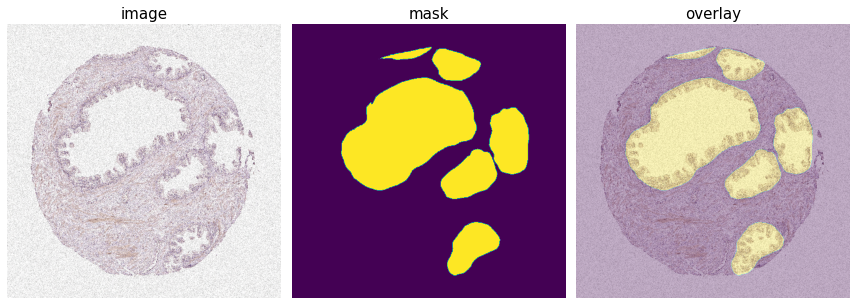

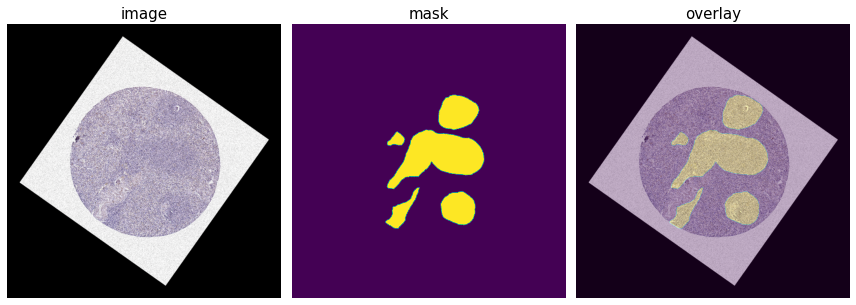

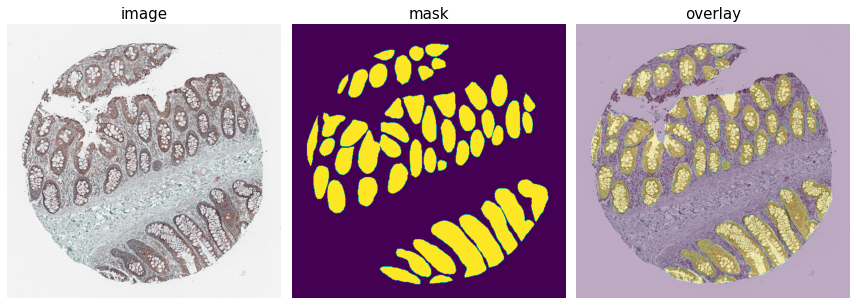

In [19]:
items = next(iter(train_loader))
imgs = items["image"].permute((0, 2, 3, 1))
msks = items["mask"].permute((0, 2, 3, 1))
print(imgs.size(), msks.size())

# torch.unique(msks)

import matplotlib.pyplot as plt
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')
            
        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

plot_batch(imgs, msks, size=3)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="training"><center>Training</center></h3>

In [20]:
log.write('** start training here! **\n')
log.write('   batch_size = %d \n'%(batch_size))
log.write('                     |-------------- VALID---------|---- TRAIN/BATCH ----------------\n')
log.write('rate     iter  epoch | dice   loss   tp     tn     | loss           | time           \n')
log.write('-------------------------------------------------------------------------------------\n')

valid_loss = np.zeros(4,np.float32)
train_loss = np.zeros(2,np.float32)
batch_loss = np.zeros_like(train_loss)
sum_train_loss = np.zeros_like(train_loss)
sum_train = 0

start_timer = time.time()
iteration = start_iteration
epoch = start_epoch
rate = 0
accum_iter = 4


while iteration < num_iteration:
    for t, batch in enumerate(train_loader):

        if iteration%iter_save==0:
            if iteration != start_iteration:
                torch.save({
                    'state_dict': net.state_dict(),
                    'iteration': iteration,
                    'epoch': epoch,
                }, out_dir + '/checkpoint/%08d.model.pth' %  (iteration))
                pass


        if (iteration%iter_valid==0):
            valid_loss = validate(net, valid_loader)
            pass
        
        # if (iteration%1000==0):
        #     valid_infer(net)
        #     pass

        if (iteration%iter_log==0) or (iteration%iter_valid==0):
            print('\r', end='', flush=True)
            log.write(message(mode='log') + '\n')


        # learning rate schduler ------------
        rate = get_learning_rate(optimizer)

        # one iteration update  -------------
        batch_size = len(batch['index'])
        
        #print(batch_size, iteration, epoch)
        batch['image'] = batch['image'].half().cuda()
        batch['mask' ] = batch['mask' ].half().cuda()
        batch['organ'] = batch['organ'].cuda()

        # normal training =------------------------------
        # net.train()
        # net.output_type = ['loss']
        # if 1:
        #     with amp.autocast(enabled = is_amp):
        #         output = net(batch)
        #         loss0  = output['bce_loss'].mean()
        #         loss1  = output['aux2_loss'].mean()

        #     optimizer.zero_grad()
        #     scaler.scale(loss0+0.2*loss1).backward()

        #     scaler.unscale_(optimizer)
        #     scaler.step(optimizer)
        #     scaler.update()
        

        # WITH GRAD ACCUM =-----------------------------
        net.train()
        net.output_type = ['loss']
        if 1:
            with amp.autocast(enabled = is_amp):
                output = net(batch)
                loss0  = output['bce_loss'].mean()
                loss1  = output['aux2_loss'].mean()
                loss = loss0+0.2*loss1
                loss = loss / accum_iter 

            # optimizer.zero_grad()
            scaler.scale(loss).backward()
            
            # remove if grad accum not required
            if ((t + 1) % accum_iter == 0) or (t + 1 == len(train_loader)):
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            


        # print statistics  =--------
        batch_loss[:2] = [loss0.item(),loss1.item()]
        sum_train_loss = batch_loss
        sum_train += 1
        if t % 100 == 0:
            train_loss = sum_train_loss / (sum_train + 1e-12)
            sum_train_loss[...] = 0
            sum_train = 0

        print('\r', end='', flush=True)
        print(message(mode='print'), end='', flush=True)
        epoch += 1 / len(train_loader)
        iteration += 1
    
    torch.cuda.empty_cache()
    
log.write('\n')
log.close()

5.00e-5   00012024  184.98 | 0.724  0.106  0.0000  0.000   | 0.075  0.079   | 6653.2981860637665 End 0.000   | 58.35236048698425 End5.00e-5   00000100    1.54 | 0.396  0.567  0.0000  0.000   | 0.495  0.641   | 151.0156033039093 End5.00e-5   00000200    3.08 | 0.540  0.302  0.0000  0.000   | 0.406  0.529   | 208.3940987586975 End5.00e-5   00000300    4.62 | 0.585  0.230  0.0000  0.000   | 0.455  0.565   | 263.73612213134766 End5.00e-5   00000400    6.15 | 0.604  0.196  0.0000  0.000   | 0.211  0.266   | 322.23161935806274 End5.00e-5   00000500    7.69 | 0.594  0.185  0.0000  0.000   | 0.159  0.213   | 378.3984160423279 End5.00e-5   00000600    9.23 | 0.633  0.174  0.0000  0.000   | 0.243  0.279   | 436.480516910553 End5.00e-5   00000700   10.77 | 0.637  0.169  0.0000  0.000   | 0.151  0.183   | 492.8678286075592 End5.00e-5   00000800   12.31 | 0.598  0.145  0.0000  0.000   | 0.146  0.175   | 551.6034433841705 End5.00e-5   00000900   13.85 | 0.647  0.174  0.0000  0.000   | 0.165  0.201  

In [21]:
# def image_to_tensor(image, mode='bgr'): #image mode
#     if mode=='bgr':
#         image = image[:,:,::-1]
#     x = image
#     x = x.transpose(2,0,1)
#     x = np.ascontiguousarray(x)
#     x = torch.tensor(x, dtype=torch.float)
#     return x

# def tensor_to_image(x, mode='bgr'):
#     image = x.data.cpu().numpy()
#     image = image.transpose(1,2,0)
#     if mode=='bgr':
#         image = image[:,:,::-1]
#     image = np.ascontiguousarray(image)
#     image = image.astype(np.float32)
#     return image

# def mask_to_tensor(mask):
#     x = mask
#     x = torch.tensor(x, dtype=torch.float)
#     return x

# def tensor_to_mask(x):
#     mask = x.data.cpu().numpy()
#     mask = mask.astype(np.float32)
#     return mask

In [22]:
# valid_num = 0
# valid_probability = []
# valid_mask = []
# valid_loss = 0

# net = net.eval()
# start_timer = time.time()
# for t, batch in enumerate(valid_loader):

#     net.output_type = ['loss', 'inference']
#     with torch.no_grad():
#         with amp.autocast(enabled = is_amp):

#             batch_size = len(batch['index'])
#             batch['image'] = batch['image'].cuda()
#             batch['mask' ] = batch['mask' ].cuda()
#             batch['organ'] = batch['organ'].cuda()

#             output = net(batch)
#             loss0  = output['bce_loss'].mean()

#     valid_probability.append(output['probability'].data.cpu().numpy())
#     valid_mask.append(batch['mask'].data.cpu().numpy())
#     valid_num += batch_size
#     valid_loss += batch_size*loss0.item()

#     organ = batch['organ'].data.cpu().numpy()
#     image = batch['image']
#     mask  = batch['mask']
#     probability  = output['probability']

#     for b in range(batch_size):
#         m = tensor_to_image(image[b])
#         t = tensor_to_mask(mask[b,0])
#         p = tensor_to_mask(probability[b,0])

In [23]:
# import matplotlib.pyplot as plt

# plt.imshow(m), m.shape

In [24]:
# plt.imshow(t), t.shape

In [25]:
# plt.imshow(p), p.shape